In [ ]:
# '=== Header Start ==='
# Title:       Section4_Extract_regulome_from_ESC_data
# Author:      Wanqi Li
# Date:        20240531
# Purpose:     Extracting regulome with isoform resolution from ESC data mentioned in Section 4
# Source Data: Joung, J. et al. A transcription factor atlas of directed differentiation. Cell 186, 209-229.e26 (2023).
# '=== Header End ==='

In [4]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import math
from scipy import stats
import re
import csv
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from upsetplot import plot
from upsetplot import generate_counts
from upsetplot import from_memberships
from brokenaxes import brokenaxes
from collections import Counter
import sklearn.metrics as sm
import pickle
import random
import multiprocessing as mp
import builtins
import os
import sys
sc.logging.print_header()

#### read data

In [2]:
# read TFAtlas_subsample (103G)
# 671,453 cells covering 3,266 TFs
TFAtlas_subsample_annData = sc.read_h5ad("/storage/disk1/wq/2023-A transcription factor atlas of directed differentiation/GSE217460_210322_TFAtlas_subsample.h5ad/210322_TFAtlas_subsample.h5ad")

In [3]:
# Cells that expressed <7,000 genes and <5% mitochondrial reads were retained
# TF Atlas, >700 genes
# print basic info of dataset
print("TFAtlas_subsample, 671,453 cells covering 3,266 TFs")
print("max counts:\t", max(TFAtlas_subsample_annData.obs["n_counts"]))
print("min counts:\t", min(TFAtlas_subsample_annData.obs["n_counts"]))
print("max genes:\t", max(TFAtlas_subsample_annData.obs["n_genes"]))
print("min genes:\t", min(TFAtlas_subsample_annData.obs["n_genes"]))
print("max percent_mito:\t", max(TFAtlas_subsample_annData.obs["percent_mito"]))

TFAtlas_subsample, 671,453 cells covering 3,266 TFs
max counts:	 14973.0
min counts:	 769.0
max genes:	 5915
min genes:	 700
max percent_mito:	 0.049967970699071884


In [4]:
# extract TF name from TFORF name
for i in range (TFAtlas_subsample_annData.obs.shape[0]):
    TFAtlas_subsample_annData.obs.loc[TFAtlas_subsample_annData.obs.index[i], "TF2"] = TFAtlas_subsample_annData.obs.loc[TFAtlas_subsample_annData.obs.index[i], "TF"]
    if TFAtlas_subsample_annData.obs.loc[TFAtlas_subsample_annData.obs.index[i], "TF"] in ["TFORF3549-GFP", "TFORF3550-mCherry"]:
        TFAtlas_subsample_annData.obs.loc[TFAtlas_subsample_annData.obs.index[i], "TF2"] = "control"
    TFAtlas_subsample_annData.obs.loc[TFAtlas_subsample_annData.obs.index[i], "TFtype"] = re.split('-', TFAtlas_subsample_annData.obs.loc[TFAtlas_subsample_annData.obs.index[i], "TF"])[1]
TFAtlas_subsample_annData.obs

,TF,batch,louvain,n_counts,n_genes,percent_mito,dpt_pseudotime,v_pseudotime,TF2,TFtype
"R1.07,R2.80,R3.02,P1.38-0-0",TFORF3021-DLX4,0,0,2875.0,2006,0.020870,0.011229,0.009950,TFORF3021-DLX4,DLX4
"R1.08,R2.52,R3.41,P1.30-0-0",TFORF3021-DLX4,0,3,3529.0,2304,0.027203,0.010818,0.008924,TFORF3021-DLX4,DLX4
"R1.09,R2.21,R3.87,P1.30-0-0",TFORF3021-DLX4,0,1,4311.0,2706,0.022269,0.011743,0.003441,TFORF3021-DLX4,DLX4
"R1.10,R2.84,R3.12,P1.46-0-0",TFORF3021-DLX4,0,4,1146.0,956,0.018325,0.022796,0.045567,TFORF3021-DLX4,DLX4
"R1.11,R2.84,R3.45,P1.46-0-0",TFORF3021-DLX4,0,1,4105.0,2698,0.024361,0.010921,0.006056,TFORF3021-DLX4,DLX4
...,...,...,...,...,...,...,...,...,...,...
"R1.29,R2.64,R3.18,P1.62-3-1",TFORF3469-ZNF438,1,6,5425.0,3217,0.019539,0.427166,0.592940,TFORF3469-ZNF438,ZNF438
"R1.36,R2.31,R3.09,P1.62-3-1",TFORF3469-ZNF438,1,3,4342.0,2734,0.020037,0.010961,0.007187,TFORF3469-ZNF438,ZNF438
"R1.52,R2.33,R3.67,P1.62-3-1",TFORF3469-ZNF438,1,6,10564.0,4857,0.013537,0.719953,0.660546,TFORF3469-ZNF438,ZNF438
"R1.87,R2.35,R3.24,P1.62-3-1",TFORF3469-ZNF438,1,3,3641.0,2439,0.015930,0.011047,0.007500,TFORF3469-ZNF438,ZNF438


unique  TF  names:	 3266
unique  TFtype  names:	 1714


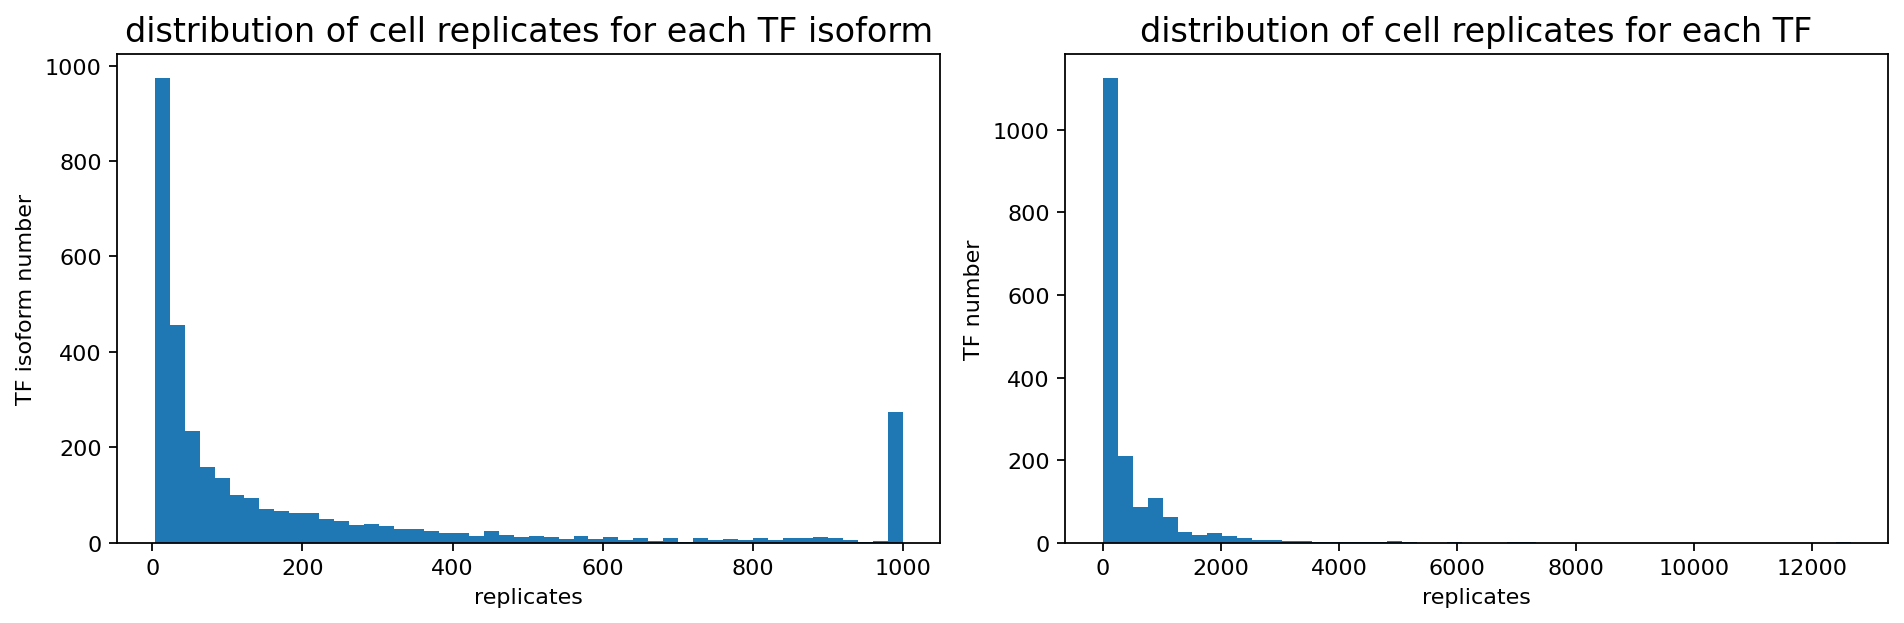

In [5]:
# check unique TF names
plt.figure(figsize=(12, 4), dpi=160) 

# TF isoform name
TF_names = TFAtlas_subsample_annData.obs["TF"].to_list()
TF_name_unique = sorted(set(TF_names))
print("unique ", "TF", " names:\t", len(TF_name_unique))
TF_names_count = Counter(TF_names)
plt.subplot(1,2,1)
plt.hist(TF_names_count.values(), bins = 50)
plt.ylabel("TF isoform" + " number", fontsize=10)
plt.xlabel("replicates", fontsize=10)   
plt.title("distribution of cell replicates for each "+ "TF isoform", fontsize=15)  

TFtype_names = TFAtlas_subsample_annData.obs["TFtype"].to_list()
TFtype_name_unique = sorted(set(TFtype_names))
print("unique ", "TFtype", " names:\t", len(TFtype_name_unique))
TFtype_names_count = Counter(TFtype_names)
plt.subplot(1,2,2)
plt.hist(TFtype_names_count.values(), bins = 50)
plt.ylabel("TF" + " number", fontsize=10)
plt.xlabel("replicates", fontsize=10)   
plt.title("distribution of cell replicates for each "+ "TF", fontsize=15)  
plt.tight_layout() 
# plt.savefig('../image/distribution_of_cell_replicates.png')
# plt.close()

In [6]:
# with open('./data/variables/TF_name_unique.pkl', 'wb') as f:
#     pickle.dump(TF_name_unique, f)
# with open('./data/variables/TF_names_count.pkl', 'wb') as f:
#     pickle.dump(TF_names_count, f)
# with open('./data/variables/TFtype_name_unique.pkl', 'wb') as f:
#     pickle.dump(TFtype_name_unique, f)
# with open('./data/variables/TFtype_names_count.pkl', 'wb') as f:
#     pickle.dump(TFtype_names_count, f)
TF_names_count_df = pd.DataFrame({
    "TF_name": TF_names_count.keys(),
    "count": TF_names_count.values()
})
TFtype_names_count_df = pd.DataFrame({
    "TFtype_name": TFtype_names_count.keys(),
    "count": TFtype_names_count.values()
})
# with open('./data/variables/TF_names_count_df.pkl', 'wb') as f:
#     pickle.dump(TF_names_count_df, f)
# with open('./data/variables/TFtype_names_count_df.pkl', 'wb') as f:
#     pickle.dump(TFtype_names_count_df, f)

1714


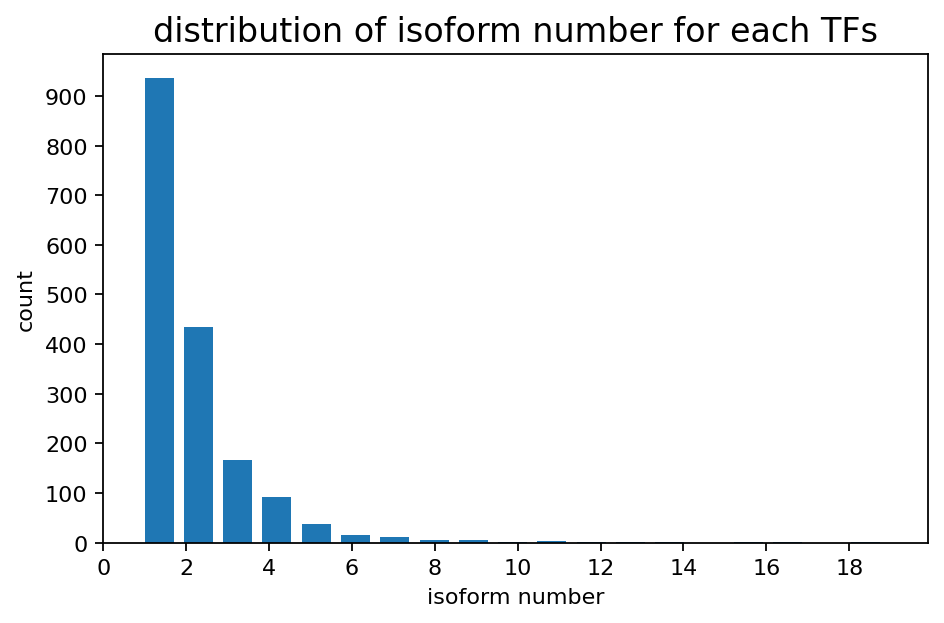

In [7]:
# plot distribution of isoform number for each TF
isoform_count_dict = {}
isoform_dict = {}
for TF in TFtype_name_unique:
    tmp_obs = TFAtlas_subsample_annData.obs[TFAtlas_subsample_annData.obs["TFtype"] == TF]
    tmp_obs = tmp_obs["TF"].to_list()
    isoform_count_dict[TF] = len(sorted(set(tmp_obs)))
    isoform_dict[TF] = sorted(set(tmp_obs))
print(len(isoform_count_dict))
isoform_count = pd.DataFrame()
isoform_count["TF"] = isoform_count_dict.keys()
isoform_count["isoform_count"] = isoform_count_dict.values()
# plot
plt.figure(figsize=(6, 4), dpi=160)
# plot histogram of all exp_diff ----
plt.hist(isoform_count["isoform_count"], bins = max(isoform_count["isoform_count"]), width = 0.7)
plt.ylabel("count", fontsize=10)
plt.xlabel("isoform number", fontsize=10)   
plt.xticks(range(0, max(isoform_count["isoform_count"]), 2))
plt.yticks(range(0, 1000, 100))
plt.title("distribution of isoform number for each TFs", fontsize=15)  
plt.tight_layout() 
# plt.savefig('./image/distribution_of_isoform.png')

# with open('./data/variables/isoform_count_dict.pkl', 'wb') as f:
#     pickle.dump(isoform_count_dict, f)
# with open('./data/variables/isoform_dict.pkl', 'wb') as f:
#     pickle.dump(isoform_dict, f)
# with open('./data/variables/isoform_count.pkl', 'wb') as f:
#     pickle.dump(isoform_count, f)

In [8]:
TF_control_list = [
    "GFP", "mCherry"
]
print("control  number:\t", len(TF_control_list), "types containing 2000 records")

control  number:	 2 types containing 2000 records


In [9]:
# get TF names without control
TFtype_name_unique_TF = copy.deepcopy(TFtype_name_unique)
for control in TF_control_list:
    if control in TFtype_name_unique_TF:
        TFtype_name_unique_TF.remove(control)
        print(control, " removed")
# with open('./data/variables/TFtype_name_unique_TF.pkl', 'wb') as f:
#     pickle.dump(TFtype_name_unique_TF, f)

GFP  removed
mCherry  removed


In [ ]:
TF_name_TF = TF_names_count_df.loc[~TF_names_count_df["TF_name"].isin(["TFORF3549-GFP", "TFORF3550-mCherry"]), "TF_name"]
TF_name_TF = TF_name_TF.sort_values()
TF_name_TF = TF_name_TF.to_list()
len(TF_name_TF)

#### calculate DEG

In [1]:
def wq_subgroup_and_rank_genes_group(annData, groupby="TF2", subgroup = "", reference="control", method='wilcoxon', tie_correct = True, use_raw=True,
                                     flag_save_DEG = False, path_DEG = "./data/.pkl",
                                     flag_save_Mat = False, path_Mat = "./data/.csv"):
    print(subgroup + "\tRunning")
    annData_focus = annData[(annData.obs[groupby] == reference)
                            | (annData.obs[groupby] == subgroup)]
    print(subgroup + "\tCalculating DEG")
    sc.tl.rank_genes_groups(annData_focus, groupby=groupby, reference=reference, method=method, tie_correct = tie_correct, use_raw=use_raw)
    annData_focus_DEG = annData_focus.uns['rank_genes_groups']
    # save DEG
    if flag_save_DEG:
        print(subgroup + "\tSaving pkl\t" + path_DEG)
        with builtins.open(path_DEG, 'wb') as f:
            pickle.dump(annData_focus_DEG, f)
            
    print(subgroup + "\tGenerating Mat")
    groups = annData_focus_DEG['names'].dtype.names
    annData_focus_DEG_Mat = pd.DataFrame(
    {group + '_' + key: annData_focus_DEG[key][group]
     for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']})
    # save result
    if flag_save_Mat:
        print(subgroup + "\tSaving csv\t" + path_Mat)
        annData_focus_DEG_Mat.to_csv(path_Mat, index = True, sep = ",")
    
    return(annData_focus_DEG_Mat)

In [ ]:
# calculate DEG by isoform subsample in parralle
for i in range(len(TF_name_TF)):
    TF_name = TF_name_TF[i]
    if not TF_name in ["TFORF3549-GFP", "TFORF3550-mCherry"]:
        flag_save_DEG = True
        path_DEG = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/pkl/"+TF_name+".pkl"
        if os.path.exists(path_DEG):
            flag_save_DEG = False
            # print("Existed:\t" + path_DEG)
        
        flag_save_Mat = True
        path_Mat = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/csv/"+TF_name+".csv"
        if os.path.exists(path_Mat):
            flag_save_Mat = False
            # print("Existed:\t" + path_Mat)
        
        if (not flag_save_DEG) and (not flag_save_Mat):
            continue
        print(TF_name)
        p = mp.Process(target=wq_subgroup_and_rank_genes_group, args=(TFAtlas_subsample_annData, 
                                                                      "TF2", TF_name, "control", 'wilcoxon', True, True,
                                                                      flag_save_DEG, path_DEG,
                                                                      flag_save_Mat, path_Mat))
        p.start()
        # pool.apply_async(wq_subgroup_and_rank_genes_group, args=(TFAtlas_subsample_annData,
        #                                                          "TF2", TF_name, "control", 'wilcoxon', True, True,
        #                                                          flag_save_DEG, path_DEG,
        #                                                          flag_save_Mat, path_Mat))
# pool.close()

In [ ]:
# get all csv
csv_path = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/csv/"
csv_list = os.listdir(csv_path)
csv_list.sort()

In [ ]:
# remove zero count and self and save
def wq_filter_rank_genes_group(annData, df, focus_TF, name_control, flag_save_csv, path_csv):
    # get all gene names
    name_all_genes = annData.raw.var_names
    # get sample names of group
    focus_sample_control = annData.obs[annData.obs["TF"].isin(name_control)].index
    focus_sample_TF = annData.obs[annData.obs["TF"] == focus_TF].index
    # get X
    raw_X_focus_control = annData.raw[focus_sample_control, name_all_genes].X
    raw_X_focus_TF = annData.raw[focus_sample_TF, name_all_genes].X
    # get mean counts
    gene_mean_control = pd.DataFrame({
        "gene": name_all_genes,
        "logcounts": np.mean(raw_X_focus_control, axis = 0)})
    gene_mean_TF = pd.DataFrame({
        "gene": name_all_genes,
        "logcounts": np.mean(raw_X_focus_TF, axis = 0)})
    # genes with zero counts
    zero_gene = pd.merge(gene_mean_control.loc[gene_mean_control["logcounts"] == 0, "gene"],
                        gene_mean_TF.loc[gene_mean_TF["logcounts"] == 0, "gene"],
                        how = 'outer')
    print(focus_TF, ": find", len(zero_gene), "zero genes in", len(name_all_genes))
    # add itself
    focus_TF_name = np.array(focus_TF.split("-")[1])
    zero_gene.loc[len(zero_gene)] = focus_TF_name
    # do filtering
    df_filter = df.loc[~df[focus_TF+"_names"].isin(zero_gene["gene"]), :]
    # save csv
    if flag_save_csv:
        print(focus_TF, ": saving", len(df_filter), "remains")
        df_filter.to_csv(path_csv, index = True, sep = ",")
    return()
    

In [ ]:
csv_path = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/csv/"
csv_list = os.listdir(csv_path)
csv_list.sort()

In [ ]:
for csv_name in csv_list:
    print("Handling", csv_name)
    focus_TF = csv_name.split(".")[0]
    df = pd.read_csv(csv_path + csv_name, index_col=0)
    path_csv = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/filtered_csv/" + focus_TF + ".csv"
    # wq_filter_rank_genes_group(TFAtlas_subsample_annData_tmp, df,
    #                            focus_TF, ["TFORF3549-GFP", "TFORF3550-mCherry"],
    #                            True, path_csv)
    p = mp.Process(target=wq_filter_rank_genes_group, args=(TFAtlas_subsample_annData, df,
                                                            focus_TF, ["TFORF3549-GFP", "TFORF3550-mCherry"],
                                                            True, path_csv))
    p.start()

In [ ]:
def wq_merge_DEG_csv(csv_path, flag_save_all, path_all):
    # get all csv
    csv_list = os.listdir(csv_path)
    csv_list.sort()
    # save all csv
    TFAtlas_subsample_raw_DEG_Mat = pd.DataFrame()
    # merge
    for csv_name in csv_list[0:2]:
        print("Merging", csv_name)
        tmp = pd.read_csv(csv_path + csv_name, index_col=0)
        if len(TFAtlas_subsample_raw_DEG_Mat) == 0:
            TFAtlas_subsample_raw_DEG_Mat = tmp
        else:
            TFAtlas_subsample_raw_DEG_Mat = TFAtlas_subsample_raw_DEG_Mat.join(tmp)
        
        print("Full Mat: ", TFAtlas_subsample_raw_DEG_Mat.shape)
    # save
    if flag_save_all:
        TFAtlas_subsample_raw_DEG_Mat.to_csv(path_all, index = True, sep = ",")
    return(TFAtlas_subsample_raw_DEG_Mat)

In [ ]:
TFAtlas_subsample_raw_DEG_Mat = wq_merge_DEG_csv(csv_path = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/filtered_csv/",
                                                 flag_save_all=True, path_all="../data/Dataset_TFAtlas/TFAtlas_subsample_raw_DEG_wilcoxon_Mat_tie=t_filtered.csv")
TFAtlas_subsample_raw_DEG_Mat

In [ ]:
def wq_rank_genes_group_to_long(csv_path, flag_save_long, path_long):
    csv_path = csv_path
    csv_list = os.listdir(csv_path)
    csv_list.sort()

    DEG_long = pd.DataFrame(
        {
            "tf": [],
            "target": [],
            "log2FC": [],
            "p_adj": []
        }
    )

    for i in range(len(csv_list)):
        csv_name = csv_list[i]
        print("runnning: ", i, " in ", len(csv_list), ": \t", csv_name)
        DEG_Mat = pd.read_csv(csv_path + csv_name, index_col=0)
        name_TF = csv_name.split('.')[0]
        DEG_long_tmp = pd.DataFrame(
            {
                key: DEG_Mat[key]
                for key in [name_TF + "_"+ 'names', name_TF + "_"+ 'logfoldchanges', name_TF + "_"+ 'pvals_adj']
            }
        )
        DEG_long_tmp.columns = ["target", "log2FC", "p_adj"]
        DEG_long_tmp["tf"] = name_TF
        DEG_long = pd.concat([DEG_long, DEG_long_tmp])
    DEG_long["-log10p_adj"] = -DEG_long.p_adj.apply(math.log10)
    if flag_save_long:
        DEG_long.to_csv(path_long, index = True, sep = ",")
    return(DEG_long)

In [ ]:
TFAtlas_subsample_raw_DEG_long = wq_rank_genes_group_to_long(csv_path = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/filtered_csv/", 
                                                             flag_save_long = True, path_long = "../data/Dataset_TFAtlas/TFAtlas_subsample_raw_DEG_wilcoxon_long_tie=t_filtered.csv")
TFAtlas_subsample_raw_DEG_long

In [9]:
TFAtlas_subsample_raw_DEG_long = pd.read_csv("../data/Dataset_TFAtlas/TFAtlas_subsample_raw_DEG_wilcoxon_long_tie=t_filtered.csv", index_col=0)

In [ ]:
def wq_draw_volcano(DEG_long, cutoff_log2FC = 1, cutoff_p_adj = 0.05,
                    title = "vocalno", flag_save_pic = False, path_pic = "./image/.png"):
    DEG_long.loc[(DEG_long.log2FC > cutoff_log2FC)&(DEG_long.p_adj < cutoff_p_adj),'type']='up'
    DEG_long.loc[(DEG_long.log2FC < -cutoff_log2FC)&(DEG_long.p_adj < cutoff_p_adj),'type']='down'
    DEG_long.loc[(abs(DEG_long.log2FC) <= cutoff_log2FC)|(DEG_long.p_adj >= cutoff_p_adj),'type']='nosig'
    # plot
    # plot log2FC and p_adj distribution
    # 先设置一下自己的颜色
    palette = {"down":"#01c5c4",
               "up":"#ff414d", 
               "nosig":"#686d76"}
    # sns.set_palette(sns.color_palette(colors))

    # 绘图
    plt.figure(figsize=(4, 4), dpi=160)
    ax=sns.scatterplot(x='log2FC', y='-log10p_adj',data=DEG_long,
                       hue='type',#颜色映射
                       palette=palette,
                       edgecolor = None,#点边界颜色
                       s=2,#点大小
                       )
    plt.xlim(-np.max(np.abs(DEG_long["log2FC"]))-1, np.max(np.abs(DEG_long["log2FC"]))+1)
    # 标签
    ax.set_title(title)
    ax.set_xlabel("log2FC")
    ax.set_ylabel("-log10(pvalue)")

    #移动图例位置
    ax.legend(loc='center right', bbox_to_anchor=(0.95,0.76), ncol=1)
    if flag_save_pic:
        plt.savefig(path_pic, bbox_inches='tight')

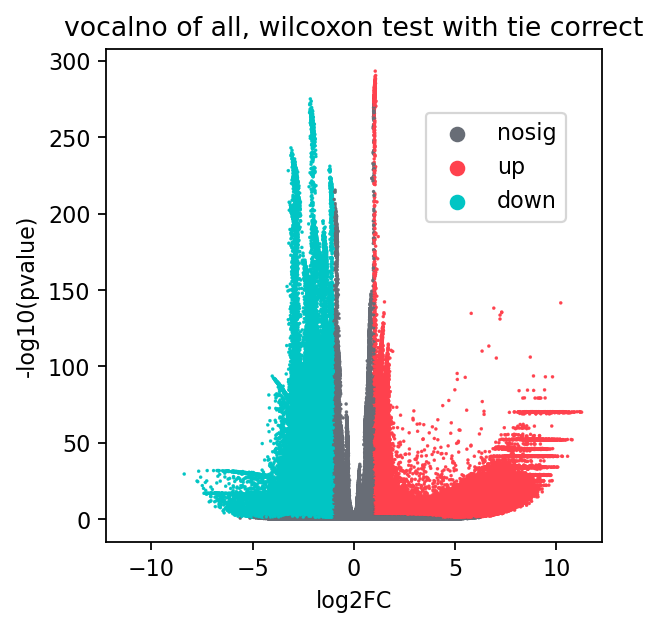

In [ ]:
wq_draw_volcano(TFAtlas_subsample_raw_DEG_long, cutoff_log2FC = 1, cutoff_p_adj = 0.05,
                title = "vocalno of all, wilcoxon test with tie correct",
                flag_save_pic = True, path_pic = '../data/Dataset_TFAtlas/image/volcano_all_wilcoxon_tie=t_filtered.png')

In [ ]:
TFAtlas_subsample_raw_DEG_long.groupby('type').count()

,tf,target,log2FC,p_adj,-log10p_adj
type,,,,,
down,507970,507970,507970,507970,507970
nosig,46142620,46142620,46142620,46142620,46142620
up,2869775,2869775,2869775,2869775,2869775


#### handle multi isoform

In [ ]:
# save multi isoform in one file
csv_path = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/filtered_csv/"
save_path = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/merged_csv/"
for TF in isoform_dict.keys():
    if TF in ["mCherry", "GFP"]:
        continue
    print("handling", TF)
    DEG_Mat_all = pd.DataFrame()
    for TFname in isoform_dict[TF]:
        csv_name = TFname + ".csv"
        print("reading", csv_name)
        df_tmp = pd.read_csv(csv_path + csv_name, index_col=0)
        df_tmp.set_index(TFname+"_names", inplace=True)
        df_tmp.index.name = "gene"
        if len(DEG_Mat_all) == 0:
            DEG_Mat_all = df_tmp
        else:
            DEG_Mat_all = DEG_Mat_all.join(df_tmp, how='outer')
    print("saving", TF)
    DEG_Mat_all.to_csv(save_path+TF+".csv", index = True, sep = ",")

handling AATF
reading TFORF2521-AATF.csv
saving AATF
handling ABL1
reading TFORF2442-ABL1.csv
saving ABL1
handling ACTL6A
reading TFORF2698-ACTL6A.csv
reading TFORF3379-ACTL6A.csv
saving ACTL6A
handling ADAR
reading TFORF1735-ADAR.csv
reading TFORF1736-ADAR.csv
saving ADAR
handling ADNP2
reading TFORF2556-ADNP2.csv
saving ADNP2
handling AEBP2
reading TFORF1312-AEBP2.csv
reading TFORF1313-AEBP2.csv
reading TFORF1314-AEBP2.csv
saving AEBP2
handling AFF2
reading TFORF1234-AFF2.csv
reading TFORF1235-AFF2.csv
saving AFF2
handling AFF3
reading TFORF1230-AFF3.csv
reading TFORF1231-AFF3.csv
saving AFF3
handling AFF4
reading TFORF1229-AFF4.csv
saving AFF4
handling AHR
reading TFORF1577-AHR.csv
saving AHR
handling AHRR
reading TFORF1893-AHRR.csv
reading TFORF1894-AHRR.csv
saving AHRR
handling AIRE
reading TFORF0431-AIRE.csv
saving AIRE
handling AKNA
reading TFORF1224-AKNA.csv
reading TFORF1225-AKNA.csv
saving AKNA
handling ALX1
reading TFORF1843-ALX1.csv
saving ALX1
handling ALX3
reading TFORF31

In [ ]:
def wq_filter_consensus_for_multi_isoform(isoform_dict, csv_path, csv_name, flag_save, save_path):
    TF = csv_name.split('.')[0]
    print("handling ", TF)
    DEG_Mat_all = pd.read_csv(csv_path + csv_name, index_col=0)
    index_logFC = [name + "_logfoldchanges" 
      for name in isoform_dict[TF]]
    index_p = [name + "_pvals_adj" 
      for name in isoform_dict[TF]]
    
    DEG_MAT_consensus = pd.DataFrame({
        TF + "_"+ 'names': [], 
        TF + "_"+ 'logfoldchanges': [], 
        TF + "_"+ 'pvals_adj': []
    })
    for gene in DEG_Mat_all.index:
        if (all(item >= 0 for item in DEG_Mat_all.loc[gene, index_logFC]) or all(item < 0 for item in DEG_Mat_all.loc[gene, index_logFC])):
            tmp = [gene, np.mean(DEG_Mat_all.loc[gene, index_logFC]), np.mean(DEG_Mat_all.loc[gene, index_p])]
            DEG_MAT_consensus.loc[len(DEG_MAT_consensus)] = tmp
    if flag_save:
      print("saving ", TF)
      DEG_MAT_consensus.to_csv(save_path+TF+".csv", index = True, sep = ",")
    return()

In [ ]:
# merge by TF
csv_path = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/merged_csv/"
save_path = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/consensus_csv/"
isoform_dict = isoform_dict
csv_list = os.listdir(csv_path)
csv_list.sort()
for csv_name in csv_list:
    p = mp.Process(target=wq_filter_consensus_for_multi_isoform, args=(isoform_dict, 
                                                                       csv_path, csv_name, 
                                                                       True, save_path))
    p.start()

handling  AATF


handling  ABL1
handling  ACTL6A
handling  ADAR
handling  ADNP2
handling  AEBP2
handling  AFF2
handling  AFF3
handling  AFF4
handling  AHR
handling  AHRR
handling  AIRE
handling  AKNA
handling  ALX1
handling  ALX3
handling  ALX4
handling  ALYREF
handling  ANHX
handling  AP2B1

APEX1 handling handling  AR

ARGFX handling handling handling handling  ARID3A  
ARID3CARID3B

handling  ARID4B
handling  ARID5A
handling  ARID5B
handling  ARNT
handling  ARNT2
handling  ARNTL
handling  ARNTL2
handling  ARX
handling  ASCL1
handling  ASCL2
handling  ASCL3
handling  ASCL4
handling  ASCL5
handling  ATF1
handling  ATF2
handling  ATF3
handling  ATF4
handling  ATF5
handling  ATF6
handling  ATF6B
handling  ATF7
handling  ATMIN
handling  ATOH1
handling  ATOH7
handling  ATOH8
handling  BACH1
handling  BACH2
handling  BARHL1
handling  BARHL2
handling  BARX1
handling  BARX2
handling  BATF
handling  BATF2
handling  BATF3
handling  BBX
handling  BCL11A
handling  BCL11B
handling  BCL3
handling  BCL6
handling  

saving  saving ZNF81 
ZNF808saving 
 ZNF679
saving  ZNF76saving saving 
  ZNF331ZNF814

saving  saving ZNF676 
ZNF675
saving  ZNF641
saving  ZNF823
saving saving   TCF15ZNF625

saving  ZFP90
saving  ZNF777
saving  ZNF726
saving  ZNF408
saving  ZNF718saving 
 ZNF654
saving  TAL2
saving saving   TAF13SUB1

saving  saving ZNF714 
ZNF827
saving  ZNF501
saving  ZNF84
saving  ZNF517
saving  ZNF91
saving  saving ZNF737
 ZNF850
saving saving saving    ZFP82ZNF772ZNF799

saving 
 ZNF358
saving  ZNF716
saving  ZNF735
saving  ZNF805
saving  SULT2A1
saving  ZNF677
saving  ZNF736
saving  ZNF90
saving  ZNF780A
saving  ZSCAN32
saving  ZNF844
saving  ZNF846
saving  ZNF586
saving saving   ZNF92ZNF621

saving  ZNF829
saving  ZNF692
saving  saving ZNF865 
ZNF770
saving  TCF19
saving  ZNF436
saving  ZSCAN20
saving  ZNF687
saving  ZNF83
saving  ZNF691
saving  YBX1
saving  saving ZNF732 
ZNF653
saving  YWHAE
saving  ZBTB9
saving  ZNF697
saving  saving ZNF551 
ZNF749
saving  ZNF597
saving  ZNF280C
saving  ZN

In [24]:
# merge all interactions
# DEG_consensus_long = wq_rank_genes_group_to_long(csv_path = "../data/Dataset_TFAtlas/DEG_wilcoxon_Mat_tie=t/consensus_csv/", 
#                                                  flag_save_long = True, path_long = "../data/Dataset_TFAtlas/TFAtlas_subsample_raw_DEG_wilcoxon_long_tie=t_consensus.csv")
DEG_consensus_long = pd.read_csv("../data/Dataset_TFAtlas/TFAtlas_subsample_raw_DEG_wilcoxon_long_tie=t_consensus.csv", index_col=0)
DEG_consensus_long

,tf,target,log2FC,p_adj,-log10p_adj
0,AATF,FZD9,7.911272,4.662357e-38,37.331394
1,AATF,LOC107985904,7.394675,5.433679e-38,37.264906
2,AATF,LOC107985126,6.611301,6.391757e-30,29.194380
3,AATF,MIR133A1HG,5.780084,2.844353e-25,24.546017
4,AATF,ALDH1A1,6.103384,1.255712e-24,23.901110
...,...,...,...,...,...
19070,ZZZ3,PTMA,-0.859622,2.267830e-53,52.644389
19071,ZZZ3,RN7SK,-2.984073,7.438448e-57,56.128518
19072,ZZZ3,ACTB,-1.231749,6.600510e-57,56.180423
19073,ZZZ3,HIST1H3B,-2.739933,1.152316e-58,57.938428


#### other regulon

In [9]:
# current regulon database
regulon_TD = pd.read_csv("../data/regulon/regulon_TD.csv")

In [17]:
# remain target in ESC data
regulon_TD_sub = regulon_TD[regulon_TD["target"].isin(TFAtlas_subsample_raw_DEG_long["target"].to_list())]
regulon_TD_sub.shape

(415553, 4)

In [22]:
all_confidence = np.unique(regulon_TD_sub["confidence"])
all_confidence

array(['A', 'A&T', 'A(T)', 'B', 'B&T', 'B(T)', 'C', 'C&T', 'C(T)', 'D',
       'D&T', 'D(T)', 'E', 'E&T', 'E(T)', 'T', 'T(A)', 'T(B)'],
      dtype=object)

1541


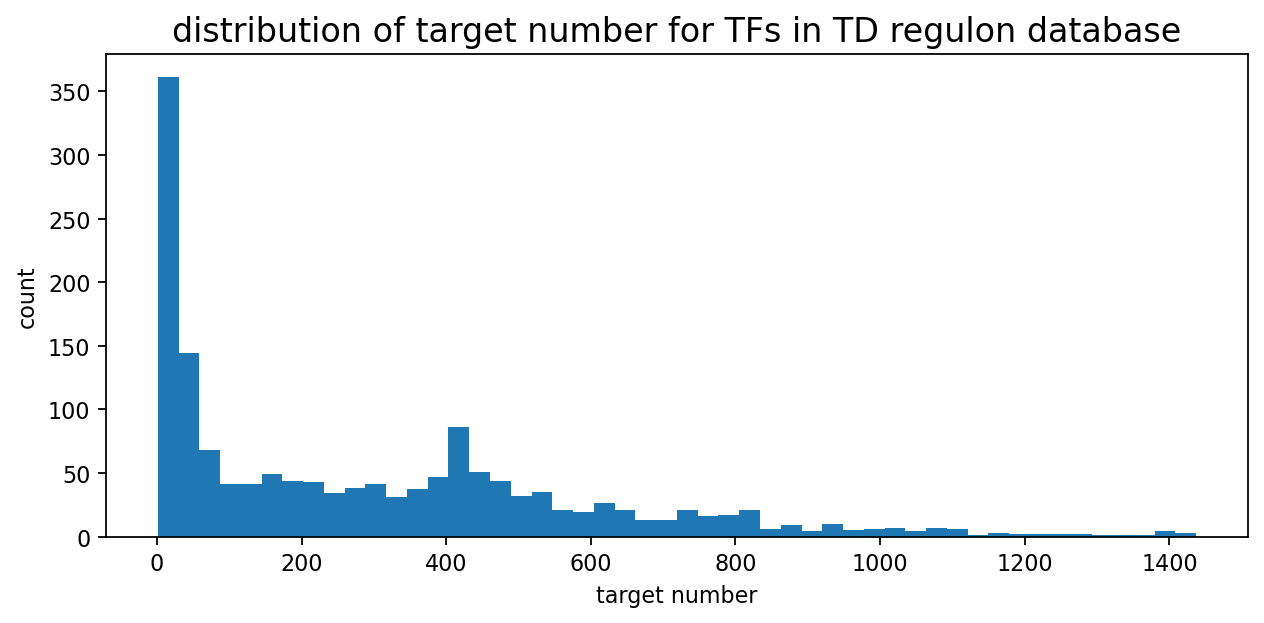

In [ ]:
# count target num for each TF
regulon_count_dict = {}
for TF in np.unique(regulon_TD["tf"]):
    regulon_count_dict[TF] = len(regulon_TD[regulon_TD["tf"] == TF])
print(len(regulon_count_dict))
regulon_count = pd.DataFrame()
regulon_count["TF"] = regulon_count_dict.keys()
regulon_count["target_count"] = regulon_count_dict.values()

# plot
plt.figure(figsize=(8, 4), dpi=160)
# plot histogram of all exp_diff ----
plt.hist(regulon_count["target_count"], bins = 50)
plt.ylabel("count", fontsize=10)
plt.xlabel("target number", fontsize=10)   
plt.title("distribution of target number for TFs in TD regulon database", fontsize=15)  
plt.tight_layout() 
# plt.savefig('../data/Dataset_TFAtlas/image/distribution_of_target_in_regulon_TD.png')

#### check cutoff

In [26]:
def wq_filter_regulon_E(DEG_consensus_long, 
                        cutoff_log2FC, cutoff_p_adj, 
                        flag_save_regulon_E = False, path_save_regulon_E = "./data/.csv",
                        verbose = True):
    DEG_consensus_long.index = range(len(DEG_consensus_long))
    DEG_consensus_long_filter = DEG_consensus_long[(np.abs(DEG_consensus_long["log2FC"]) >= cutoff_log2FC) & (DEG_consensus_long["p_adj"] <= cutoff_p_adj)].copy()
    if verbose:
        print(len(DEG_consensus_long_filter), "rows remain")
    # DEG_consensus_long_filter.loc[DEG_consensus_long["log2FC"] >= cutoff_log2FC, "mor_ESC"] = 1
    # DEG_consensus_long_filter.loc[DEG_consensus_long["log2FC"] <= -cutoff_log2FC, "mor_ESC"] = -1
    DEG_consensus_long_filter.loc[:,'ESC_mor'] = pd.cut(x = DEG_consensus_long.loc[:,'log2FC'], 
                                                  bins=[min(DEG_consensus_long.loc[:,'log2FC'])-1, 0, max(DEG_consensus_long.loc[:,'log2FC'])+1],
                                                  labels=[-1,1])
    # handle circumstances without one category
    DEG_consensus_long_filter['ESC_mor'] = pd.Categorical(DEG_consensus_long_filter['ESC_mor'], categories=[-1,0,1])
    if flag_save_regulon_E:
        if verbose:
            print("saving " + path_save_regulon_E)
        DEG_consensus_long_filter.to_csv(path_save_regulon_E, index = True, sep = ",")
    return(DEG_consensus_long_filter)

In [ ]:
DEG_consensus_long = DEG_consensus_long
cutoff_list_p_adj = [0.05]
cutoff_list_log2FC = np.arange(0,10,0.1)
flag_save_regulon_E = False
path_save_regulon_E = "../data/Dataset_TFAtlas/"
flag_save_regulon_TDE = False
path_save_regulon_TDE = "../data/Dataset_TFAtlas/"
verbose = True

# connectivity
cutoff_connectivity_mat = pd.DataFrame(index=TFtype_name_unique_TF)
cutoff_connectivity_mean = pd.DataFrame({
    "log2FC_cutoff": [],
    "mean_connectivity": []
})

for cutoff_p_adj in cutoff_list_p_adj:
    for cutoff_log2FC in cutoff_list_log2FC:
        if verbose:
            print("running: p_adj cutoff = ", cutoff_p_adj, "log2FC cutoff = ", cutoff_log2FC)

        # extract regulon E
        file_save_regulon_E = path_save_regulon_E + "regulon_E_FC=" + str(cutoff_log2FC) + "_p=" + str(cutoff_p_adj) + ".csv"
        regulon_E = wq_filter_regulon_E(DEG_consensus_long,
                                        cutoff_log2FC = cutoff_log2FC, cutoff_p_adj = cutoff_p_adj, 
                                        flag_save_regulon_E = flag_save_regulon_E, path_save_regulon_E = file_save_regulon_E,
                                        verbose = verbose)
        regulon_E_tf_count = regulon_E.groupby("tf").count()
        regulon_E_tf_count["cutoff="+str(cutoff_log2FC)] = regulon_E_tf_count.iloc[:,0]
        cutoff_connectivity_mat = cutoff_connectivity_mat.join(regulon_E_tf_count["cutoff="+str(cutoff_log2FC)])
        print("mean connectivity = ", np.mean(regulon_E_tf_count["cutoff="+str(cutoff_log2FC)]))
        cutoff_connectivity_mean.loc[len(cutoff_connectivity_mean)] = [cutoff_log2FC, np.mean(regulon_E_tf_count["cutoff="+str(cutoff_log2FC)])]
cutoff_connectivity_mat

running: p_adj cutoff =  0.05 log2FC cutoff =  0.0
2570160 rows remain
mean connectivity =  1575.8185162477007
running: p_adj cutoff =  0.05 log2FC cutoff =  0.1
2569550 rows remain
mean connectivity =  1575.444512568976
running: p_adj cutoff =  0.05 log2FC cutoff =  0.2
2563393 rows remain
mean connectivity =  1571.6695278969958
running: p_adj cutoff =  0.05 log2FC cutoff =  0.30000000000000004
2524065 rows remain
mean connectivity =  1547.5567136725936
running: p_adj cutoff =  0.05 log2FC cutoff =  0.4
2423888 rows remain
mean connectivity =  1486.1361128142244
running: p_adj cutoff =  0.05 log2FC cutoff =  0.5
2263863 rows remain
mean connectivity =  1388.0214592274679
running: p_adj cutoff =  0.05 log2FC cutoff =  0.6000000000000001
2053832 rows remain
mean connectivity =  1259.2470876762723
running: p_adj cutoff =  0.05 log2FC cutoff =  0.7000000000000001
1812359 rows remain
mean connectivity =  1111.1949724095646
running: p_adj cutoff =  0.05 log2FC cutoff =  0.8
1562306 rows rem

,cutoff=0.0,cutoff=0.1,cutoff=0.2,cutoff=0.30000000000000004,cutoff=0.4,cutoff=0.5,cutoff=0.6000000000000001,cutoff=0.7000000000000001,cutoff=0.8,cutoff=0.9,...,cutoff=9.0,cutoff=9.1,cutoff=9.200000000000001,cutoff=9.3,cutoff=9.4,cutoff=9.5,cutoff=9.600000000000001,cutoff=9.700000000000001,cutoff=9.8,cutoff=9.9
AATF,663.0,663.0,663.0,663.0,663.0,663.0,663.0,662.0,662.0,660.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABL1,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,220.0,...,8.0,6.0,5.0,5.0,3.0,2.0,1.0,NaN,NaN,NaN
ACTL6A,1823.0,1823.0,1823.0,1817.0,1810.0,1797.0,1777.0,1688.0,1451.0,1153.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADAR,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ADNP2,343.0,343.0,343.0,343.0,343.0,343.0,343.0,343.0,343.0,343.0,...,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZXDA,1003.0,1003.0,1003.0,1003.0,1001.0,1000.0,997.0,993.0,984.0,970.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZXDB,157.0,157.0,157.0,157.0,157.0,157.0,157.0,157.0,157.0,157.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZXDC,150.0,150.0,150.0,150.0,150.0,150.0,150.0,148.0,147.0,139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# with open('../data/Dataset_TFAtlas/variables/cutoff_connectivity_mean.pkl', 'wb') as f:
#     pickle.dump(cutoff_connectivity_mean, f)
# with open('../data/Dataset_TFAtlas/variables/cutoff_connectivity_mat.pkl', 'wb') as f:
#     pickle.dump(cutoff_connectivity_mat, f)
with open('../data/Dataset_TFAtlas/variables/cutoff_connectivity_mean.pkl', 'rb') as f:
    cutoff_connectivity_mean = pickle.load(f)
with open('../data/Dataset_TFAtlas/variables/cutoff_connectivity_mat.pkl', 'rb') as f:
    cutoff_connectivity_mat = pickle.load(f)

In [13]:
# compare distribution of connection with regulon_TD
regulon_TD_tf_count = regulon_TD.groupby("tf").count()
regulon_TD_tf_count = regulon_TD_tf_count.sort_values(by = ["target"], ascending = True)
regulon_TD_tf_count

,confidence,target,mor
tf,,,
NELFB,1,1,1
MYOCD,1,1,1
TFPT,1,1,1
DNMT3L,1,1,1
TLE3,1,1,1
...,...,...,...
FOXJ3,1398,1398,1398
NFATC3,1401,1401,1401
TCF7L1,1431,1431,1431


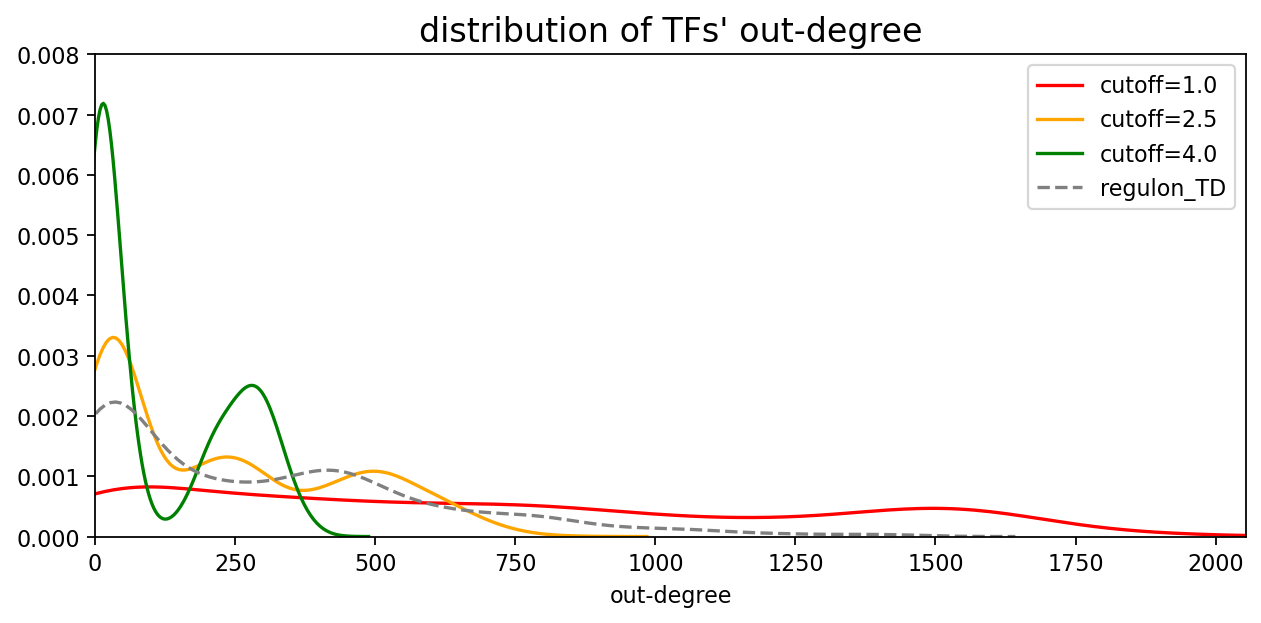

In [ ]:
plt.figure(figsize=(8, 4), dpi=160)
# plt.hist(cutoff_connectivity_mat["cutoff=2.5"], bins = 50, alpha = 0.5, label = "cutoff=2.5")
# plt.hist(regulon_TD_tf_count["target"], bins = 50, alpha = 0.5, label = "regulon_TD")
sns.kdeplot(cutoff_connectivity_mat["cutoff=1.0"], label = "cutoff=1.0", color = "r")
sns.kdeplot(cutoff_connectivity_mat["cutoff=2.5"], label = "cutoff=2.5", color = "orange")
sns.kdeplot(cutoff_connectivity_mat["cutoff=4.0"], label = "cutoff=4.0", color = "g")
sns.kdeplot(regulon_TD_tf_count["target"], label = "regulon_TD", color = "gray", linestyle = "--")
plt.ylabel("", fontsize=10)
plt.xlabel("out-degree", fontsize=10)  
# plt.xticks(ticks = [0], labels = [""], fontsize=10)   
plt.xlim(0, max(np.max(cutoff_connectivity_mat["cutoff=1.0"]), np.max(regulon_TD_tf_count["target"]))) 
plt.ylim(0,0.008)
# plt.title("regulon_ESC, cutoff = 2.5", fontsize=12)


plt.title("distribution of TFs' out-degree", fontsize=15)
plt.legend()
plt.tight_layout()
plt.savefig('./image/out-degree_cutoff.png')

In [14]:
cutoff_list_log2FC = np.arange(0,10,0.1)

# use KS test to calculate similarity of connectivity distribution
connectivity_KS = pd.DataFrame({
    "log2FC_cutoff": [],
    "KS_stat": [],
    "KS_p": []
})

for cutoff_log2FC in cutoff_list_log2FC:
    KS_stat, KS_p = stats.ks_2samp(regulon_TD_tf_count["target"], cutoff_connectivity_mat["cutoff=" + str(cutoff_log2FC)])
    connectivity_KS.loc[len(connectivity_KS)] = [cutoff_log2FC, KS_stat, KS_p]

connectivity_KS

,log2FC_cutoff,KS_stat,KS_p
0,0.0,0.438416,1.144604e-140
1,0.1,0.438416,1.144604e-140
2,0.2,0.438416,1.144604e-140
3,0.3,0.438416,1.144604e-140
4,0.4,0.438416,1.144604e-140
...,...,...,...
95,9.5,0.967290,0.000000e+00
96,9.6,0.970794,0.000000e+00
97,9.7,0.974299,0.000000e+00
98,9.8,0.977804,0.000000e+00


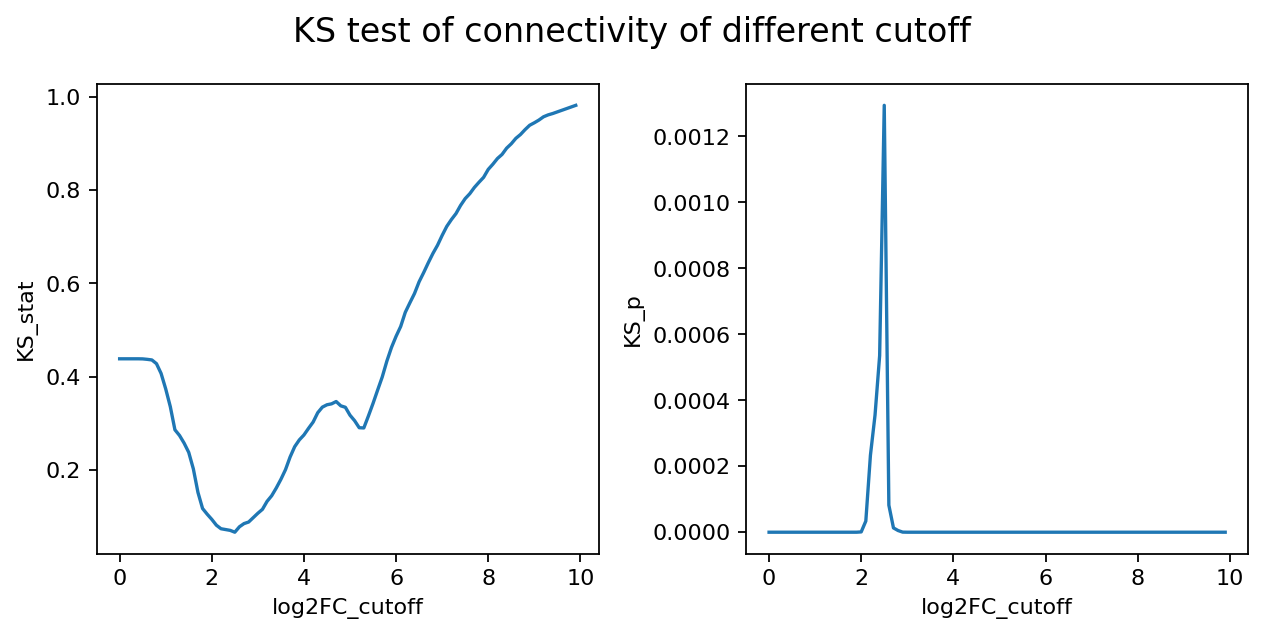

In [16]:
plt.figure(figsize=(8, 4), dpi=160)
plt.subplot(1,2,1)
plt.plot(connectivity_KS["log2FC_cutoff"], connectivity_KS["KS_stat"])
plt.ylabel("KS_stat", fontsize=10)
plt.xlabel("log2FC_cutoff", fontsize=10)   

plt.subplot(1,2,2)
plt.plot(connectivity_KS["log2FC_cutoff"], connectivity_KS["KS_p"])
plt.ylabel("KS_p", fontsize=10)
plt.xlabel("log2FC_cutoff", fontsize=10)   

plt.suptitle("KS test of connectivity of different cutoff", fontsize=15)
# plt.legend()
plt.tight_layout()
plt.savefig('../data/Dataset_TFAtlas/image/cutoff_connectivity_KS_test.pdf')

#### choose log2FC cutoff = 2.5

In [18]:
def wq_merge_TDE(regulon_E, regulon_TD, confidence_list, 
                 flag_save_regulon_TDE = False, path_save_regulon_TDE = "./data/.csv",
                 verbose = True):
    if verbose:
        print("merging regulon TDE")
    # merge with TD
    regulon_TDE = pd.merge(regulon_E.loc[:, ["tf", "target", "ESC_mor"]], regulon_TD[regulon_TD["confidence"].isin(confidence_list)], how = "outer")
    regulon_TDE.fillna(0, inplace=True)
    if verbose:
        print("regulon TDE length: ", len(regulon_TDE))
    if flag_save_regulon_TDE:
        if verbose:
            print("saving regulon TDE")
        regulon_TDE.to_csv(path_save_regulon_TDE, index = True, sep = ",")
    return(regulon_TDE)

In [20]:
def wq_calculate_precision(regulon_TDE, cutoff_log2FC, cutoff_p_adj, verbose):
    confusion_mat = sm.confusion_matrix(regulon_TDE["ESC_mor"], regulon_TDE["mor"], labels = [1,-1,0])
    # confusion_mat
    TP = confusion_mat[0,0] + confusion_mat[1,1]
    FP = confusion_mat[0,1] + confusion_mat[1,0]
    FN = confusion_mat[2,0] + confusion_mat[2,1]
    new = confusion_mat[0,2] + confusion_mat[1,2]
    new_a = confusion_mat[0,2]
    new_i = confusion_mat[1,2]
    activation = confusion_mat[0,0] + confusion_mat[0,1] + confusion_mat[0,2]
    inhibition = confusion_mat[1,0] + confusion_mat[1,1] + confusion_mat[1,2]

    if (TP+FP) == 0:
        precision = np.nan
    else:
        precision = TP/(TP+FP)
    if (TP+FN) == 0:
        recall = np.nan
    else:
        recall = TP/(TP+FN)
    if (precision + recall) == 0:
        F1 = np.nan
    else:
        F1 = 2*precision*recall/(precision + recall)
    if TP == 0:
        logTP = np.nan
    else:
        logTP = math.log(TP, 10)
    if FP == 0:
        logFP = np.nan
    else:
        logFP = math.log(FP, 10)
    if FN == 0:
        logFN = np.nan
    else:
        logFN = math.log(FN, 10)
    if FP*FN == 0:
        score1 = np.nan
    else:
        score1 = TP*TP/(FP*FN)
    if FP+FN == 0:
        score2 = np.nan
    else:
        score2 = TP/(FP+FN)

    if verbose:
        print(confusion_mat)
        print("TP\t= ", TP)
        print("FP\t= ", FP)
        print("FN\t= ", FN)
        print("new\t= ", new)
        print("new+\t= ", new_a)
        print("new-\t= ", new_i)
        print("activation\t= ", activation)
        print("inhibition\t= ", inhibition)
        print("precision\t= ", precision)
        print("recall\t= ", recall)
        print("F1-score\t= ", F1)
        print("logTP\t= ", logTP)
        print("logFP\t= ", logFP)
        print("logFN\t= ", logFN)
        print("TP*TP/(FP*FN)\t= ", score1)
        print("TP/(FP+FN)\t= ", score2)
    return([cutoff_log2FC, cutoff_p_adj, TP, FP, FN, new, new_a, new_i, activation, inhibition, precision, recall, F1, logTP, logFP, logFN, score1, score2])

In [21]:
def wq_calculate_precision_cutoff_input_long(DEG_consensus_long, regulon_TD, confidence_list, 
                                             cutoff_list_log2FC, cutoff_list_p_adj, 
                                             flag_save_regulon_E = False, path_save_regulon_E = "./data/",
                                             flag_save_regulon_TDE = False, path_save_regulon_TDE = "./data/",
                                             verbose = True):
    stat = pd.DataFrame({
        "log2FC_cutoff": [],
        "p_adj_cutoff": [],
        "TP": [],
        "FP": [],
        "FN": [],
        "new": [],
        "new+": [],
        "new-": [],
        "activation": [],
        "inhibition": [],
        "precision": [],
        "recall": [],
        "F1": [],
        "logTP": [],
        "logFP": [],
        "logFN": [],
        "TP*TP/(FP*FN)": [],
        "TP/(FP+FN)": []
    })
    
    for cutoff_p_adj in cutoff_list_p_adj:
        for cutoff_log2FC in cutoff_list_log2FC:
            if verbose:
                print("running: p_adj cutoff = ", cutoff_p_adj, "log2FC cutoff = ", cutoff_log2FC)
            
            # extract regulon E
            file_save_regulon_E = path_save_regulon_E + "regulon_E_FC=" + str(cutoff_log2FC) + "_p=" + str(cutoff_p_adj) + ".csv"
            regulon_E = wq_filter_regulon_E(DEG_consensus_long,
                                            cutoff_log2FC = cutoff_log2FC, cutoff_p_adj = cutoff_p_adj, 
                                            flag_save_regulon_E = flag_save_regulon_E, path_save_regulon_E = file_save_regulon_E,
                                            verbose = verbose)
            
            # merge regulon TDE
            file_save_regulon_TDE = path_save_regulon_TDE + "regulon_TDE_raw_FC=" + str(cutoff_log2FC) + "_p=" + str(cutoff_p_adj) + ".csv"
            regulon_TDE = wq_merge_TDE(regulon_E, regulon_TD, confidence_list = confidence_list, 
                                       flag_save_regulon_TDE = flag_save_regulon_TDE, path_save_regulon_TDE = file_save_regulon_TDE,
                                       verbose = verbose)
            
            # calculate precision
            stat.loc[len(stat)] = wq_calculate_precision(regulon_TDE, cutoff_log2FC, cutoff_p_adj, verbose)
    return(stat)

In [ ]:
stat_2_5 = wq_calculate_precision_cutoff_input_long(DEG_consensus_long, regulon_TD_sub, confidence_list = all_confidence, 
                                                      cutoff_list_log2FC = [2.5], cutoff_list_p_adj = [0.05], 
                                                      flag_save_regulon_E = True, path_save_regulon_E = "../data/Dataset_TFAtlas/",
                                                      flag_save_regulon_TDE = False, path_save_regulon_TDE = "../data/Dataset_TFAtlas/",
                                                      verbose = True)

running: p_adj cutoff =  0.05 log2FC cutoff =  2.5
366986 rows remain
saving ./data/regulon_E_FC=2.5_p=0.05.csv
merging regulon TDE
regulon TDE length:  773064
[[  1471    147 347344]
 [    75      9  17940]
 [366351  39727      0]]
TP	=  1480
FP	=  222
FN	=  406078
new	=  365284
new+	=  347344
new-	=  17940
activation	=  348962
inhibition	=  18024
precision	=  0.8695652173913043
recall	=  0.0036313849807880104
F1-score	=  0.007232566094902995
logTP	=  3.170261715394957
logFP	=  2.3463529744506384
logFN	=  5.608609461449128
TP*TP/(FP*FN)	=  0.02429746666075647
TP/(FP+FN)	=  0.0036426285995569776


#### check motif

In [ ]:
# tf-tf interaction
DEG_consensus_long_tf = DEG_consensus_long[DEG_consensus_long["target"].isin(TFtype_name_unique_TF)]
DEG_consensus_long_tf.shape

(1412023, 5)

In [ ]:
DEG_consensus_long_tf.to_csv("../data/Dataset_TFAtlas/TFAtlas_subsample_raw_DEG_wilcoxon_long_tie=t_consensus_tf.csv", index = True, sep = ",")

In [ ]:
# search for mutual inhibition
def wq_find_mutal_interaction(regulon_E_tf, mor_name = "ESC_mor", type = "both", verbose = True):
    regulon_E_tf_MI = pd.DataFrame(columns = regulon_E_tf.columns)
    if type == "inhibition":
        regulon_E_tf = regulon_E_tf[regulon_E_tf[mor_name] < 0]
    elif type == "activation":
        regulon_E_tf = regulon_E_tf[regulon_E_tf[mor_name] > 0]
    elif type == "both":
        regulon_E_tf = regulon_E_tf[regulon_E_tf[mor_name] != 0]
    else:
        print("ERROR: type should be in \"inhibition\", \"activation\", \"both\"")
        return()
    
    if verbose:
        print(len(regulon_E_tf), " lines remain")

    # for i in range(len(regulon_E_tf)):
    #     if len(regulon_E_tf[(regulon_E_tf["tf"] == regulon_E_tf.iloc[i,1]) &
    #                         (regulon_E_tf["target"] == regulon_E_tf.iloc[i,0])]):
    #         regulon_E_tf_MI.loc[len(regulon_E_tf_MI)] = regulon_E_tf.iloc[i,:]
    regulon_E_tf_MI = regulon_E_tf[regulon_E_tf.apply(lambda x:(
        (regulon_E_tf["tf"] == x["target"]) & (regulon_E_tf["target"] == x["tf"])
    ).any(), axis=1)]
    return(regulon_E_tf_MI)

In [ ]:
DEG_consensus_long_tf = DEG_consensus_long_tf
cutoff_list_p_adj = [0.05]
cutoff_list_log2FC = [2.5]
cutoff_p_adj = 0.05
cutoff_log2FC = 2.5
flag_save_regulon_E = False
path_save_regulon_E = "./data/"
flag_save_regulon_TDE = False
path_save_regulon_TDE = "./data/"
verbose = False

regulon_E_tf = wq_filter_regulon_E(DEG_consensus_long_tf,
                                    cutoff_log2FC = cutoff_log2FC, cutoff_p_adj = cutoff_p_adj,
                                    verbose = verbose)

# regulon_E_tf_MB = wq_find_mutal_interaction(regulon_E_tf, type = "both", verbose = verbose)
# if verbose:
#     print("find ", len(regulon_E_tf_MB), " mutual interaction")
regulon_E_tf_MI = wq_find_mutal_interaction(regulon_E_tf, type = "inhibition", verbose = verbose)
if verbose:
    print("find ", len(regulon_E_tf_MI), " mutual inhibition")
# regulon_E_tf_MA = wq_find_mutal_interaction(regulon_E_tf, type = "activation", verbose = verbose)
# if verbose:
#     print("find ", len(regulon_E_tf_MA), " mutual activation")

regulon_E_tf_MI.to_csv("../data/Dataset_TFAtlas/regulon_E_FC=2.5_p=0.05_mutual inhibition.csv", index = True, sep = ",")
print(len(regulon_E_tf_MI))

4


### new regulon checkings

#### merge database

In [7]:
regulon_E = pd.read_csv("../data/Dataset_TFAtlas/regulon_E_FC=2.5_p=0.05.csv", index_col=0)

In [11]:
# regulon_TDE_raw = pd.merge(regulon_E.drop("mor_num", axis=1), regulon_TD, how = "outer")
regulon_TDE_raw = pd.merge(regulon_E[["tf", "target", "ESC_mor"]], regulon_TD, how = "outer")
regulon_TDE_raw.fillna(0, inplace=True)
# regulon_TDE_raw.to_csv("vregulon_TDE_raw_FC=2.5_p=0.05.csv", index = True, sep = ",")
regulon_TDE_raw = pd.read_csv("../data/Dataset_TFAtlas/regulon_TDE_raw_FC=2.5_p=0.05.csv", index_col=0)
regulon_TDE_raw.shape

(821981, 5)

In [ ]:
regulon_TDE = regulon_TDE_raw
for i in range(len(regulon_TDE)):
    if regulon_TDE.loc[i, "ESC_mor"] != 0:
        regulon_TDE.loc[i, "confidence"] = "A"
        regulon_TDE.loc[i, "mor"] = regulon_TDE.loc[i, "ESC_mor"]
    elif regulon_TDE.loc[i, "confidence"] in("A", "T", "A&T", "B&T", "C&T", "D&T", "E&T", "A(T)", "T(A)", "T(B)"):
        regulon_TDE.loc[i, "confidence"] = "A"
    elif regulon_TDE.loc[i, "confidence"] in("B", "B(T)"):
        regulon_TDE.loc[i, "confidence"] = "B"
    elif regulon_TDE.loc[i, "confidence"] in("C", "C(T)"):
        regulon_TDE.loc[i, "confidence"] = "C"
    elif regulon_TDE.loc[i, "confidence"] in("D", "D(T)"):
        regulon_TDE.loc[i, "confidence"] = "D"
    elif regulon_TDE.loc[i, "confidence"] in("E", "E(T)"):
        regulon_TDE.loc[i, "confidence"] = "E"
regulon_TDE

,tf,target,ESC_mor,confidence,mor
0,AATF,FZD9,1.0,A,1.0
1,AATF,LOC107985904,1.0,A,1.0
2,AATF,LOC107985126,1.0,A,1.0
3,AATF,MIR133A1HG,1.0,A,1.0
4,AATF,ALDH1A1,1.0,A,1.0
...,...,...,...,...,...
821978,ZZZ3,ZBTB20,0.0,D,1.0
821979,ZZZ3,ZMYM3,0.0,D,1.0
821980,ZZZ3,ZNF462,0.0,D,1.0
821981,ZZZ3,ZNF827,0.0,D,1.0


In [12]:
# regulon_TDE = regulon_TDE.loc[:,["tf", "confidence", "target", "mor"]]
# regulon_TDE = regulon_TDE.sort_values(by = ["tf", "target"], ascending = True)
# regulon_TDE.to_csv("../data/Dataset_TFAtlas/regulon_TDE_FC=2.5_p=0.05.csv", index = False, sep = ",")
regulon_TDE = pd.read_csv("../data/Dataset_TFAtlas/regulon_TDE_FC=2.5_p=0.05.csv")

In [13]:
regulon_resource_count = from_memberships(
    [
        ["DoRothEA"],
        ["TRRUST"],
        ["ESC"],
        ["DoRothEA", "TRRUST"],
        ["DoRothEA", "ESC"],
        ["TRRUST", "ESC"],
        ["DoRothEA", "TRRUST", "ESC"]
    ],
    data = [
        len(regulon_TDE_raw[(regulon_TDE_raw["confidence"].isin(["A", "B", "C", "D", "E"]))
                            & (regulon_TDE_raw["ESC_mor"] == 0)]),
        len(regulon_TDE_raw[(regulon_TDE_raw["confidence"].isin(["T"]))
                            & (regulon_TDE_raw["ESC_mor"] == 0)]),
        len(regulon_TDE_raw[(regulon_TDE_raw["ESC_mor"] != 0)
                            & (regulon_TDE_raw["confidence"] == "0")]),
        len(regulon_TDE_raw[(regulon_TDE_raw["confidence"].isin(["A&T", "A(T)", "B&T", "B(T)", "C&T", "C(T)", "D&T", "D(T)", "E&T", "E(T)", "T(A)", "T(B)"]))
                            & (regulon_TDE_raw["ESC_mor"] == 0)]),
        len(regulon_TDE_raw[(regulon_TDE_raw["ESC_mor"] != 0) 
                            & (regulon_TDE_raw["confidence"].isin(["A", "B", "C", "D", "E"]))]),
        len(regulon_TDE_raw[(regulon_TDE_raw["ESC_mor"] != 0) 
                            & (regulon_TDE_raw["confidence"].isin(["T"]))]),
        len(regulon_TDE_raw[(regulon_TDE_raw["ESC_mor"] != 0) 
                            & (regulon_TDE_raw["confidence"].isin(["A&T", "A(T)", "B&T", "B(T)", "C&T", "C(T)", "D&T", "D(T)", "E&T", "E(T)", "T(A)", "T(B)"]))])
    ]
)
regulon_resource_count

DoRothEA  ESC    TRRUST
True      False  False     450214
False     False  True        2189
          True   False     365284
True      False  True        2592
          True   False       1685
False     True   True           4
True      True   True          13
dtype: int64

In [14]:
TF_resource_count = from_memberships(
    [
        ["human TF"],
        ["human TFome"],
        ["DoRothEA + TRRUST"],
        ["MORF library"],
        ["human TF", "human TFome"],
        ["human TF", "DoRothEA + TRRUST"],
        ["human TF", "MORF library"],
        ["human TFome", "DoRothEA + TRRUST"],
        ["human TFome", "MORF library"],
        ["DoRothEA + TRRUST", "MORF library"],
        ["human TF", "human TFome", "DoRothEA + TRRUST"],
        ["human TF", "human TFome", "MORF library"],
        ["human TF", "DoRothEA + TRRUST", "MORF library"],
        ["human TFome", "DoRothEA + TRRUST", "MORF library"],
        ["human TF", "human TFome", "DoRothEA + TRRUST", "MORF library"]
    ],
    data = [
        85,
        173,
        107,
        217,
        40,
        18,
        35,
        3,
        41,
        74,
        6,
        136,
        168,
        14,
        1151
    ]
)
TF_resource_count

DoRothEA + TRRUST  MORF library  human TF  human TFome
False              False         True      False            85
                                 False     True            173
True               False         False     False           107
False              True          False     False           217
                   False         True      True             40
True               False         True      False            18
False              True          True      False            35
True               False         False     True              3
False              True          False     True             41
True               True          False     False            74
                   False         True      True              6
False              True          True      True            136
True               True          True      False           168
                                 False     True             14
                                 True      True           1151


In [15]:
with open('../data/Dataset_TFAtlas/variables/regulon_resource_count.pkl', 'wb') as f:
    pickle.dump(regulon_resource_count, f)
with open('../data/Dataset_TFAtlas/variables/TF_resource_count.pkl', 'wb') as f:
    pickle.dump(TF_resource_count, f)
# with open('../data/Dataset_TFAtlas/variables/regulon_resource_count.pkl', 'rb') as f:
#     regulon_resource_count = pickle.load(f)
# with open('../data/Dataset_TFAtlas/variables/TF_resource_count.pkl', 'rb') as f:
#     TF_resource_count = pickle.load(f)

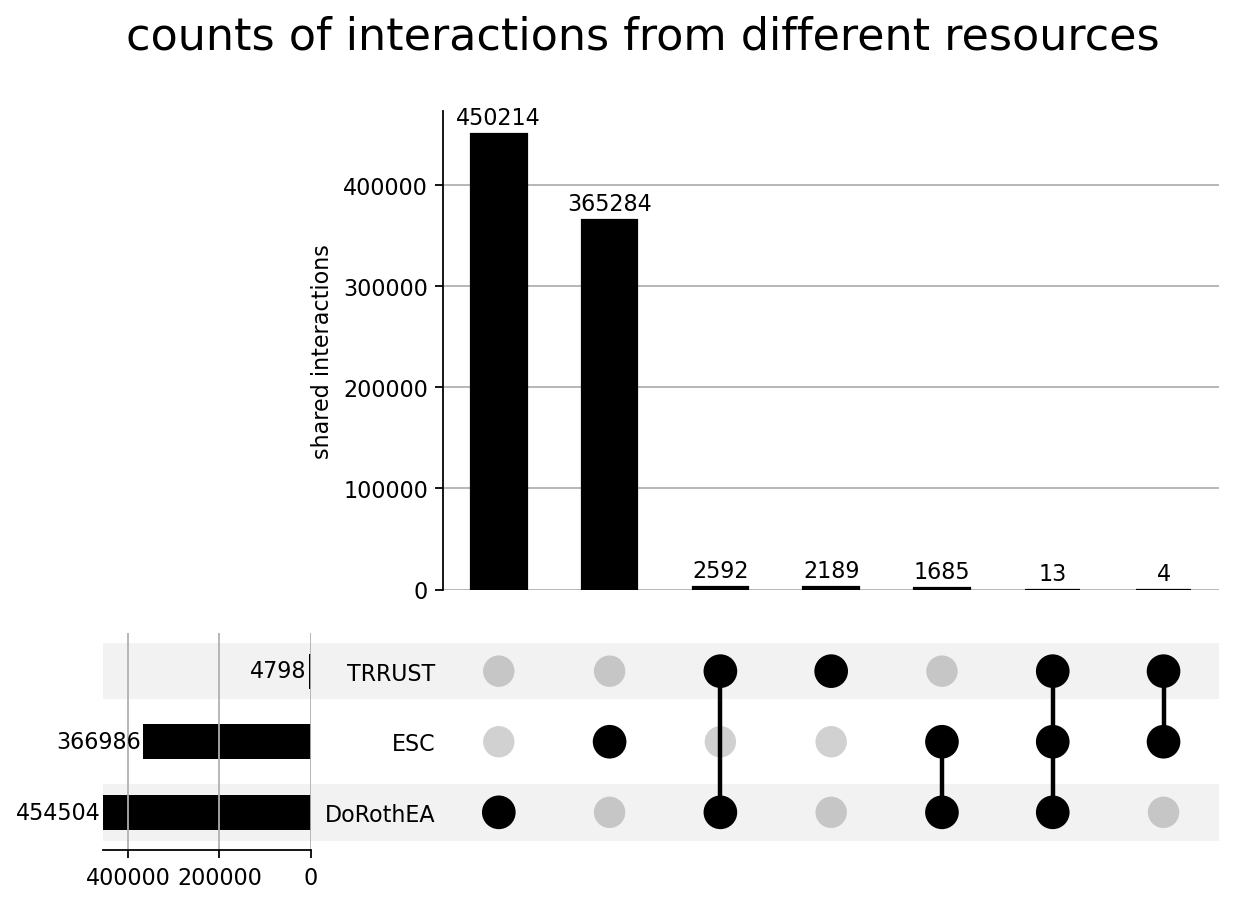

In [17]:
fig = plt.figure(figsize=(9,6), dpi=160)
plot(regulon_resource_count, fig = fig, element_size=None,
    sort_by = "cardinality", show_counts = "%d")
plt.suptitle("counts of interactions from different resources", fontsize=20)
plt.ylabel("shared interactions")
# plt.tight_layout()
# plt.show()
plt.savefig('../data/Dataset_TFAtlas/image/regulon_counts_by_resource.pdf')

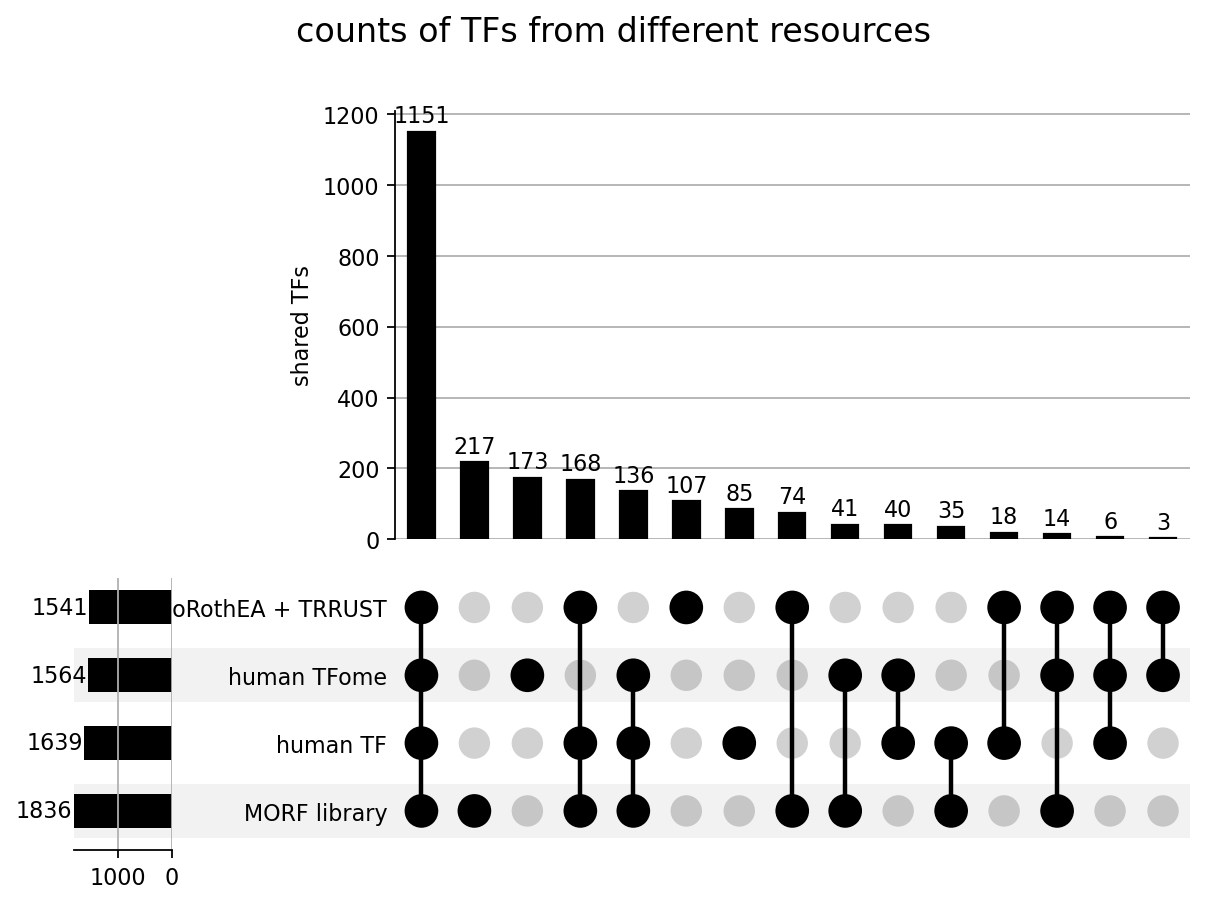

In [19]:
fig = plt.figure(figsize=(9,6), dpi=160)
plot(TF_resource_count, fig = fig, element_size=None,
    sort_by = "cardinality", show_counts = "%d")
plt.suptitle("counts of TFs from different resources", fontsize=15)
plt.ylabel("shared TFs")
# plt.tight_layout()
# plt.show()
plt.savefig('../data/Dataset_TFAtlas/image/TF_counts_by_resource.pdf')

#### connectivity

In [21]:
regulon_TD_tf_count = regulon_TD.groupby("tf").count()
regulon_TD_tf_count = regulon_TD_tf_count.sort_values(by = ["target"], ascending = True)
with open('../data/Dataset_TFAtlas/variables/regulon_TD_tf_count.pkl', 'wb') as f:
    pickle.dump(regulon_TD_tf_count, f)
# with open('../data/Dataset_TFAtlas/variables/regulon_TD_tf_count.pkl', 'rb') as f:
#     regulon_TD_tf_count = pickle.load(f)
regulon_TD_tf_count

,confidence,target,mor
tf,,,
NELFB,1,1,1
MYOCD,1,1,1
TFPT,1,1,1
DNMT3L,1,1,1
TLE3,1,1,1
...,...,...,...
FOXJ3,1398,1398,1398
NFATC3,1401,1401,1401
TCF7L1,1431,1431,1431


In [22]:
regulon_E_tf_count = regulon_E.groupby("tf").count()
regulon_E_tf_count = regulon_E_tf_count.sort_values(by = ["target"], ascending = True)
with open('../data/Dataset_TFAtlas/variables/regulon_E_tf_count.pkl', 'wb') as f:
    pickle.dump(regulon_E_tf_count, f)
# with open('../data/Dataset_TFAtlas/variables/regulon_E_tf_count.pkl', 'rb') as f:
#     regulon_E_tf_count = pickle.load(f)
regulon_E_tf_count

,target,log2FC,p_adj,-log10p_adj,ESC_mor
tf,,,,,
ERG,1,1,1,1,1
PGR,1,1,1,1,1
ZNF366,1,1,1,1,1
DAXX,1,1,1,1,1
CIITA,1,1,1,1,1
...,...,...,...,...,...
EBF2,752,752,752,752,752
ZNF660,755,755,755,755,755
ARGFX,769,769,769,769,769


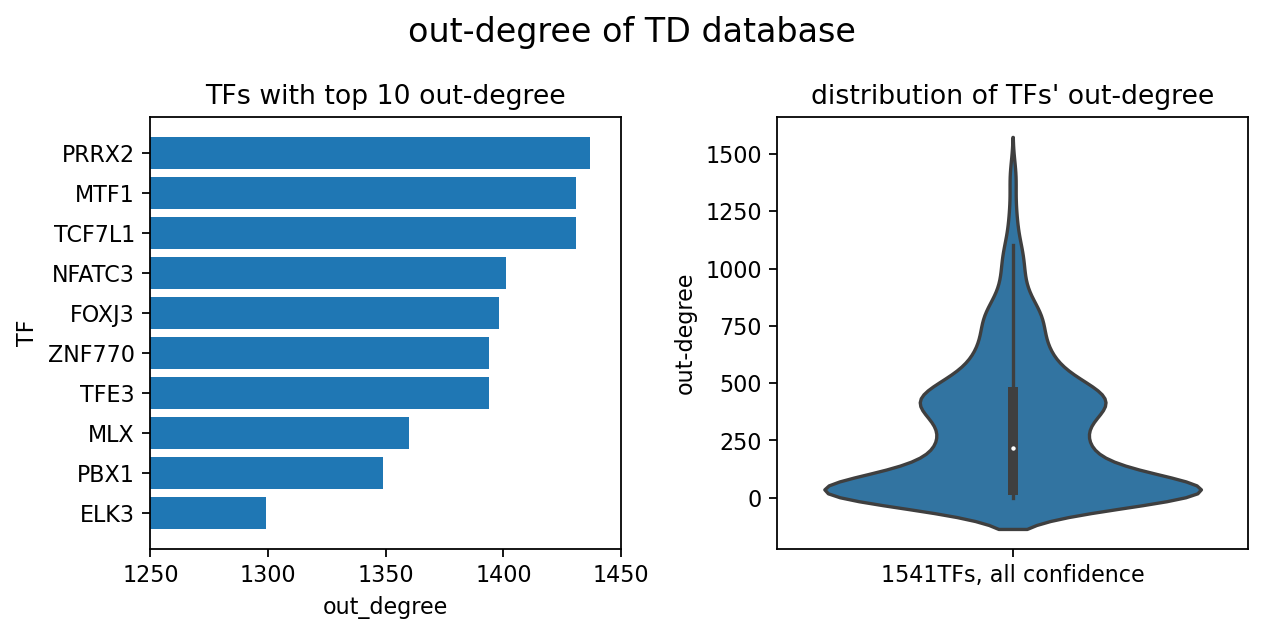

In [29]:
plt.figure(figsize=(8, 4), dpi=160)
plt.subplot(1,2,1)
plt.barh(regulon_TD_tf_count.index.to_list()[len(regulon_TD_tf_count)-10:len(regulon_TD_tf_count)], regulon_TD_tf_count.iloc[len(regulon_TD_tf_count)-10:len(regulon_TD_tf_count), 0])
plt.ylabel("TF", fontsize=10)
plt.xlabel("out_degree", fontsize=10)   
plt.xlim(1250, 1450)
plt.title("TFs with top 10 out-degree", fontsize=12)

plt.subplot(1,2,2)
sns.violinplot(data = regulon_TD_tf_count["target"])
plt.ylabel("out-degree", fontsize=10)
plt.xlabel("", fontsize=10)   
plt.xticks(ticks = [0], labels = [str(len(regulon_TD_tf_count)) + "TFs, all confidence"], fontsize=10)
# plt.xlim(0, 2) 
# plt.ylim(0, 1)
plt.title("distribution of TFs' out-degree", fontsize=12)

plt.suptitle("out-degree of TD database", fontsize=15)
plt.tight_layout()
plt.savefig('../data/Dataset_TFAtlas/image/out-degree_TD.pdf')

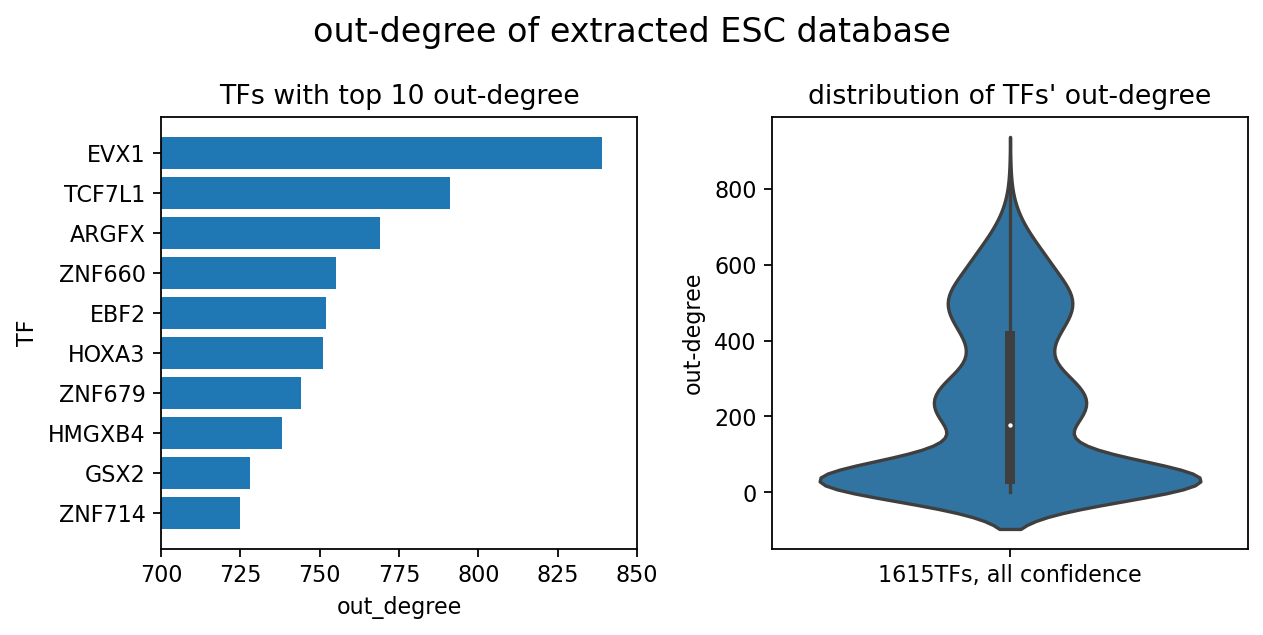

In [31]:
plt.figure(figsize=(8, 4), dpi=160)
plt.subplot(1,2,1)
plt.barh(regulon_E_tf_count.index.to_list()[len(regulon_E_tf_count)-10:len(regulon_E_tf_count)], regulon_E_tf_count.iloc[len(regulon_E_tf_count)-10:len(regulon_E_tf_count), 0])
plt.ylabel("TF", fontsize=10)
plt.xlabel("out_degree", fontsize=10)   
plt.xlim(700, 850)
plt.title("TFs with top 10 out-degree", fontsize=12)

plt.subplot(1,2,2)
sns.violinplot(data = regulon_E_tf_count["target"])
plt.ylabel("out-degree", fontsize=10)
plt.xlabel("", fontsize=10)   
plt.xticks(ticks = [0], labels = [str(len(regulon_E_tf_count)) + "TFs, all confidence"], fontsize=10)
# plt.xlim(0, 2) 
# plt.ylim(0, 1)
plt.title("distribution of TFs' out-degree", fontsize=12)

plt.suptitle("out-degree of extracted ESC database", fontsize=15)
plt.tight_layout()
plt.savefig('../data/Dataset_TFAtlas/image/out-degree_E.pdf')

#### compare with other database

In [32]:
TF_list = pd.read_csv("../data/regulon/TF_TD+3paper.csv", header=None)
TF_list.columns = ["TF"]

In [33]:
# need to run 30min
# TF num, target, interactions, activation, inhibition
regulon_TDE_radar_count = pd.DataFrame({
    "database": [],
    "TF": [],
    "target": [],
    "protein": [],
    "interaction": [],
    "activation": [],
    "inhibition": [],
    "connectivity": [],
    "TF_TF_interaction": [],
    "mutual_interaction": [],
    "mutual_activation": [],
    "mutual_inhibition": []
})

for database in ["all", "TD", "ESC"]:
# for database in ["ESC"]:
    if database == "all":
        regulon_tmp = regulon_TDE
    elif database == "TD":
        regulon_tmp = regulon_TDE_raw[regulon_TDE_raw["confidence"].isin(["A", "A&T", "A(T)", "B", "B&T", "B(T)", "C", "C&T", "C(T)", "D", "D&T", "D(T)", "E", "E&T", "E(T)", "T(A)", "T(B)",
                                                                          "T", "A&T", "A(T)", "B&T", "B(T)", "C&T", "C(T)", "D&T", "D(T)", "E&T", "E(T)", "T(A)", "T(B)"])]
    elif database == "ESC":
        regulon_tmp = regulon_E
        regulon_tmp.columns = ['tf', 'target', 'log2FC', 'p_adj', '-log10p_adj', 'mor']

    TF = sorted(set(regulon_tmp["tf"].to_list()))
    TF_num_tmp = len(TF)
    target = sorted(set(regulon_tmp["target"].to_list()))
    target_num_tmp = len(target)
    protein = sorted(set(TF + target))
    protein_num_tmp = len(protein)
    interaction_tmp = len(regulon_tmp)
    activation_tmp = len(regulon_tmp[regulon_tmp["mor"] == 1])
    inhibition_tmp = len(regulon_tmp[regulon_tmp["mor"] == -1])
    connectivity_count = regulon_tmp.groupby("tf").count().iloc[:,0]
    connectivity_tmp = np.mean(connectivity_count)

    regulon_tmp_tf = regulon_tmp[regulon_tmp["target"].isin(TF_list["TF"].values)]
    TF_TF_interaction = len(regulon_tmp_tf)
    
    regulon_tmp_tf = regulon_tmp[regulon_tmp["target"].isin(regulon_TDE['tf'])]
    regulon_tmp_tf_MB = regulon_tmp_tf[regulon_tmp_tf.apply(lambda x:(
        (regulon_tmp_tf["tf"] == x["target"]) & (regulon_tmp_tf["target"] == x["tf"])
    ).any(), axis=1)]
    mutual_interaction = len(regulon_tmp_tf_MB)

    regulon_tmp_tf_activation = regulon_tmp_tf[regulon_tmp_tf["mor"] > 0]
    regulon_tmp_tf_MA = regulon_tmp_tf_activation[regulon_tmp_tf_activation.apply(lambda x:(
        (regulon_tmp_tf_activation["tf"] == x["target"]) & (regulon_tmp_tf_activation["target"] == x["tf"])
    ).any(), axis=1)]
    mutual_activation = len(regulon_tmp_tf_MA)

    regulon_tmp_tf_inhibition = regulon_tmp_tf[regulon_tmp_tf["mor"] < 0]
    regulon_tmp_tf_MI = regulon_tmp_tf_inhibition[regulon_tmp_tf_inhibition.apply(lambda x:(
        (regulon_tmp_tf_inhibition["tf"] == x["target"]) & (regulon_tmp_tf_inhibition["target"] == x["tf"])
    ).any(), axis=1)]
    mutual_inhibition = len(regulon_tmp_tf_MI)
    
    regulon_TDE_radar_count.loc[len(regulon_TDE_radar_count)] = [
        database, TF_num_tmp, target_num_tmp, protein_num_tmp, interaction_tmp, activation_tmp, inhibition_tmp, connectivity_tmp, TF_TF_interaction, mutual_interaction, mutual_activation, mutual_inhibition
    ]

with open('../data/Dataset_TFAtlas/variables/regulon_TD&E_radar_count.pkl', 'wb') as f:
    pickle.dump(regulon_TDE_radar_count, f)
regulon_TDE_radar_count

,database,TF,target,protein,interaction,activation,inhibition,connectivity,TF_TF_interaction,mutual_interaction,mutual_activation,mutual_inhibition
0,all,1911,30465,30478,821981,759219,62762,430.131345,83291,25516,21262,204
1,TD,1541,20314,20320,456697,411803,44894,296.364049,69342,25262,21030,198
2,ESC,1615,21954,22474,366493,348488,18005,226.930650,14164,48,34,4


In [34]:
regulon_TDE_radar_ratio = copy.deepcopy(regulon_TDE_radar_count)
regulon_TDE_radar_ratio.iloc[:,1:] = regulon_TDE_radar_ratio.iloc[:,1:] / regulon_TDE_radar_ratio.max()[1:]
regulon_TDE_radar_ratio

,database,TF,target,protein,interaction,activation,inhibition,connectivity,TF_TF_interaction,mutual_interaction,mutual_activation,mutual_inhibition
0,all,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,TD,0.806384,0.666798,0.66671,0.555605,0.542403,0.715305,0.689008,0.832527,0.990045,0.989089,0.970588
2,ESC,0.845107,0.72063,0.737384,0.445866,0.459009,0.286877,0.527585,0.170054,0.001881,0.001599,0.019608


In [35]:
labels = regulon_TDE_radar_ratio.iloc[:, 1:].columns
labels

Index(['TF', 'target', 'protein', 'interaction', 'activation', 'inhibition',
       'connectivity', 'TF_TF_interaction', 'mutual_interaction',
       'mutual_activation', 'mutual_inhibition'],
      dtype='object')

In [39]:
def plot_radar(data):
    '''
    the first column of the data is the cluster name;
    the second column is the number of each cluster;
    the last are those to describe the center of each cluster.
    '''
    kinds = data.iloc[:, 0]
    labels = data.iloc[:, 1:].columns.to_list()
    centers = pd.concat([data.iloc[:, 1:], data.iloc[:,1]], axis=1)
    centers = np.array(centers)
    n = len(labels)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    labels.append(labels[0])
    
    fig = plt.figure(figsize=(6, 4), dpi=160)
    ax = fig.add_subplot(111, polar=True) # 设置坐标为极坐标
    
    # 画若干个五边形
    floor = np.floor(centers.min())     # 大于最小值的最大整数
    ceil = np.ceil(centers.max())       # 小于最大值的最小整数
    step = (ceil - floor)/3
    for i in np.arange(floor, ceil + step, step):
        ax.plot(angles, [i] * (n + 1), '--', lw=1, color='gray')
    
    # 画不同客户群的分割线
    for i in range(n):
        ax.plot([angles[i], angles[i]], [floor, ceil], '--', lw=1, color='gray')
    
    # 画不同的客户群所占的大小
    for i in range(len(kinds)):
        ax.plot(angles, centers[i], lw=3, label=kinds[i])
        # ax.fill(angles, centers[i], alpha = 0.3)
    
    ax.set_thetagrids(angles * 180 / np.pi, labels, fontsize = 10) # 设置显示的角度，将弧度转换为角度
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0.0)) # 设置图例的位置，在画布外
    
    ax.set_theta_zero_location('N')        # 设置极坐标的起点（即0°）在正北方向，即相当于坐标轴逆时针旋转90°
    ax.spines['polar'].set_visible(False)  # 不显示极坐标最外圈的圆
    ax.grid(False)                         # 不显示默认的分割线
    ax.set_yticks([])                      # 不显示坐标间隔
    
    plt.title("Comparison of different database", fontsize=15)
    plt.tight_layout()
    plt.savefig('../data/Dataset_TFAtlas/image/database_comparison.pdf')
    
    # plt.show()

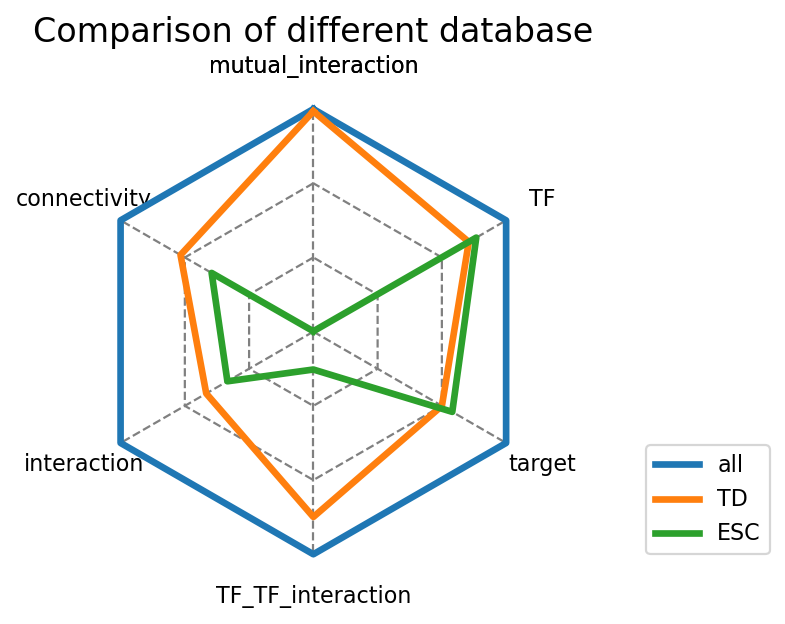

In [40]:
plot_radar(regulon_TDE_radar_ratio[["database", "mutual_interaction", "connectivity", "interaction", "TF_TF_interaction", "target", "TF"]])